In [120]:
import pandas as pd
import numpy as np

from pyincore import IncoreClient
from pyincore.analyses.socialvulnerability import SocialVulnerability
from pyincore_data.censusutil import CensusUtil
from pyincore import Dataset

In [121]:
client = IncoreClient()

Enter username:  zacbaker
Enter password:  ········


Connection successful to IN-CORE services. pyIncore version detected: 1.14.0


In [122]:
state = "florida"
county = "lee"
year = 2022

In [123]:
# get fips code to use fetch census data
fips = CensusUtil.get_fips_by_state_county(state=state, county=county)
state_code = fips[:2]
county_code = fips[2:]
fips

'12071'

In [124]:
def demographic_factors(state_number, county_number, year, geo_type="tract:*"):

    api_json_1, df_1, ds_1 = CensusUtil.get_census_data(state=state_code, county=county_code, year=year,
                                                              data_source="acs/acs5",
                                                              columns="GEO_ID,B03002_001E,B03002_003E",
                                                              geo_type=geo_type)
    df_1["factor_white_nonHispanic"] = df_1[["B03002_001E","B03002_003E"]].astype(int).apply(lambda row: row["B03002_003E"]/row["B03002_001E"] if row["B03002_001E"] != 0 else 999, axis = 1)

    api_json_2, df_2, ds_2 = CensusUtil.get_census_data(state=state_code, county=county_code, year=year,
                                                  data_source="acs/acs5",
                                                  columns="B25003_001E,B25003_002E",
                                                  geo_type=geo_type)
    df_2["factor_owner_occupied"] = df_2.astype(int).apply(lambda row: row["B25003_002E"]/row["B25003_001E"] if row["B25003_001E"] != 0 else 999, axis = 1)
    
    api_json_3, df_3, ds_3 = CensusUtil.get_census_data(state=state_code, 
                                         county=county_code, 
                                         year=year,
                                         data_source="acs/acs5",
                                         columns="B17021_001E,B17021_002E",
                                         geo_type=geo_type)
    df_3["factor_earning_higher_than_national_poverty_rate"] = df_3.astype(int).apply(lambda row: 1-row["B17021_002E"]/row["B17021_001E"] if row["B17021_001E"] != 0 else 999, axis = 1)
    
    api_json_4, df_4, ds_4 = CensusUtil.get_census_data(state=state_code, 
                                         county=county_code, 
                                         year=year,
                                         data_source="acs/acs5", 
                                         columns="B15003_001E,B15003_017E,B15003_018E,B15003_019E,B15003_020E,B15003_021E,B15003_022E,B15003_023E,B15003_024E,B15003_025E",
                                         geo_type=geo_type)
    df_4["factor_over_25_with_high_school_diploma_or_higher"] = df_4.astype(int).apply(lambda row: (row["B15003_017E"] 
                                                                                                    + row["B15003_018E"] 
                                                                                                    + row["B15003_019E"] 
                                                                                                    + row["B15003_020E"] 
                                                                                                    + row["B15003_021E"] 
                                                                                                    + row["B15003_022E"] 
                                                                                                    + row["B15003_023E"] 
                                                                                                    + row["B15003_024E"] 
                                                                                                    + row["B15003_025E"])/row["B15003_001E"] if row["B15003_001E"] != 0 else 999, axis = 1)

    if geo_type == 'tract:*':
        api_json_5, df_5, ds_5 = CensusUtil.get_census_data(state=state_code, 
                                             county=county_code, 
                                             year=year,
                                             data_source="acs/acs5",
                                             columns="B18101_001E,B18101_011E,B18101_014E,B18101_030E,B18101_033E",
                                             geo_type=geo_type)
        df_5["factor_without_disability_age_18_to_65"] = df_5.astype(int).apply(lambda row: (row["B18101_011E"] + row["B18101_014E"] + row["B18101_030E"] + row["B18101_033E"])/row["B18101_001E"] if row["B18101_001E"] != 0 else 999, axis = 1)
    
    elif geo_type == 'block%20group:*':
        api_json_5, df_5, ds_5 = CensusUtil.get_census_data(state=state_code, 
                                             county=county_code, 
                                             year=year,
                                             data_source="acs/acs5",
                                             columns="B01003_001E,C21007_006E,C21007_009E,C21007_013E,C21007_016E",
                                             geo_type=geo_type)

        df_5['factor_without_disability_age_18_to_65'] = df_5.astype(int).apply(lambda row: (row['C21007_006E']+
                                                                                 row['C21007_006E']+
                                                                                 row['C21007_009E']+
                                                                                 row['C21007_013E'])
                                                                                /row['C21007_016E'] if row["C21007_016E"] != 0 else 999, axis = 1)

    df_t = pd.concat([df_1[["GEO_ID","factor_white_nonHispanic"]],
                      df_2["factor_owner_occupied"],
                      df_3["factor_earning_higher_than_national_poverty_rate"], 
                      df_4["factor_over_25_with_high_school_diploma_or_higher"],
                      df_5["factor_without_disability_age_18_to_65"]], 
                     axis=1, join='inner')
    
    # extract FIPS from geo id
    df_t["FIPS"] = df_t.apply(lambda row: row["GEO_ID"].split("US")[1], axis = 1)
        
    return df_t

In [125]:
def national_ave_values (year, data_source="acs/acs5"):
    api_json_1, nav1, ds_1 = CensusUtil.get_census_data(state="*", county=None, year=year, data_source=data_source,
                             columns="B03002_001E,B03002_003E",geo_type=None)
    nav1 = nav1.astype(int)
    nav1_avg ={"feature": "NAV-1: White, nonHispanic", 
                "average": nav1['B03002_003E'].sum()/ nav1['B03002_001E'].sum()}

    api_json_2, nav2, ds_2 = CensusUtil.get_census_data(state="*", county=None, year=year, data_source=data_source,
                             columns="B25003_001E,B25003_002E",geo_type=None)
    nav2 = nav2.astype(int)
    nav2_avg = {"feature": "NAV-2: Home Owners", 
                "average": nav2['B25003_002E'].sum()/nav2['B25003_001E'].sum()}

    api_json_3, nav3, ds_3 = CensusUtil.get_census_data(state="*", county=None, year=year, data_source=data_source,
                             columns="B17021_001E,B17021_002E",geo_type=None)
    nav3 = nav3.astype(int)
    nav3_avg = {"feature": "NAV-3: earning higher than national poverty rate", 
                "average": 1-nav3['B17021_002E'].sum()/nav3['B17021_001E'].sum()}

    api_json_4, nav4, ds_4 = CensusUtil.get_census_data(state="*", 
                                         county=None, 
                                         year=year,
                                         data_source="acs/acs5",
                                         columns="B15003_001E,B15003_017E,B15003_018E,B15003_019E,B15003_020E,B15003_021E,B15003_022E,B15003_023E,B15003_024E,B15003_025E",
                                         geo_type=None)
    nav4 = nav4.astype(int)
    nav4['temp'] = nav4.apply(lambda row: row['B15003_017E']+row['B15003_018E']+row['B15003_019E']+
                              row['B15003_020E']+row['B15003_021E']+row['B15003_022E']+row['B15003_023E']+
                              row['B15003_024E']+row['B15003_025E'], axis = 1)
    nav4_avg = {"feature": 'NAV-4: over 25 with high school diploma or higher', 
                "average": nav4['temp'].sum()/nav4['B15003_001E'].sum()}

    api_json_5, nav5, ds_5 = CensusUtil.get_census_data(state="*", county=None, year=year, data_source=data_source,
                             columns="B18101_001E,B18101_011E,B18101_014E,B18101_030E,B18101_033E",
                                         geo_type=None)
    nav5 = nav5.astype(int)
    nav5['temp'] = nav5.apply(lambda row: row['B18101_011E']+row['B18101_014E']+row['B18101_030E']+row['B18101_033E'], axis = 1)
    nav5_avg = {"feature": 'NAV-5: without disability age 18 to 65', 
                "average": nav5["temp"].sum()/nav5["B18101_001E"].sum()}
    
    navs = [nav1_avg, nav2_avg, nav3_avg, nav4_avg, nav5_avg]
    
    return navs

In [126]:
navs = national_ave_values(year=2022)
national_vulnerability_feature_averages = Dataset.from_csv_data(navs, name="national_vulnerability_feature_averages.csv",
                                                                 data_type="incore:socialVulnerabilityFeatureAverages")

csv saved as api_20240523-133952.csv
csv saved as api_20240523-133954.csv
csv saved as api_20240523-133955.csv
csv saved as api_20240523-133956.csv
csv saved as api_20240523-133957.csv


In [127]:
geo_type = "tract:*"
social_vunlnerability_dem_factors_df = demographic_factors(state_code, county_code, year=2022, geo_type=geo_type)
social_vunlnerability_dem_factors = Dataset.from_dataframe(social_vunlnerability_dem_factors_df, 
                                                           name="social_vunlnerability_dem_factors",
                                                           data_type="incore:socialVulnerabilityDemFactors")

csv saved as api_20240523-134000.csv
csv saved as api_20240523-134002.csv
csv saved as api_20240523-134003.csv
csv saved as api_20240523-134005.csv
csv saved as api_20240523-134006.csv


In [128]:
# Configure pyincore access and the analysis with the information above

client = IncoreClient()
social_vulnerability = SocialVulnerability(client)

social_vulnerability.set_parameter("result_name", "social_vulnerabilty")
social_vulnerability.set_input_dataset("national_vulnerability_feature_averages", national_vulnerability_feature_averages)
social_vulnerability.set_input_dataset("social_vulnerability_demographic_factors", social_vunlnerability_dem_factors)

Connection successful to IN-CORE services. pyIncore version detected: 1.14.0


True

In [129]:
# Run social vulnerability damage analysis
result = social_vulnerability.run_analysis()

In [130]:
# Retrieve result dataset
result = social_vulnerability.get_output_dataset("sv_result")

# Convert dataset to Pandas DataFrame
sv_df = result.get_dataframe_from_csv()
sv_df.head()

,GEO_ID,factor_white_nonHispanic,factor_owner_occupied,factor_earning_higher_than_national_poverty_rate,factor_over_25_with_high_school_diploma_or_higher,factor_without_disability_age_18_to_65,FIPS,R1,R2,R3,R4,R5,SVS,zone
0,1400000US12071000303,0.304398,0.622924,0.794084,0.671244,0.546007,12071000303,0.522188,0.960599,0.910952,0.753846,0.996831,0.828883,Medium to High Vulnerable (zone4)
1,1400000US12071000304,0.721519,0.324147,0.931284,0.923497,0.677517,12071000304,1.237750,0.499861,1.068345,1.037141,1.236924,1.016004,Medium Vulnerable (zone3)
2,1400000US12071000305,0.080253,0.329201,0.800422,0.691824,0.591341,12071000305,0.137673,0.507655,0.918224,0.776958,1.079596,0.684021,High Vulnerable (zone5)
3,1400000US12071000306,0.203542,0.294118,0.759348,0.573745,0.651392,12071000306,0.349172,0.453553,0.871104,0.644349,1.189229,0.701481,High Vulnerable (zone5)
4,1400000US12071000401,0.344257,0.651111,0.899662,0.656484,0.588814,12071000401,0.590565,1.004066,1.032069,0.737270,1.074981,0.887790,Medium to High Vulnerable (zone4)


In [131]:
# plotting the social vulnerability data in lee county

In [247]:
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 
import contextily as ctx 
import geopandas as gpd 
!pip install seaborn
import seaborn as sns
import os 
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable

   ---------------------------------------- 0.0/294.9 kB ? eta -:--:--
   - -------------------------------------- 10.2/294.9 kB ? eta -:--:--
   -- ------------------------------------ 20.5/294.9 kB 217.9 kB/s eta 0:00:02
   ---- ---------------------------------- 30.7/294.9 kB 217.9 kB/s eta 0:00:02
   ----- --------------------------------- 41.0/294.9 kB 217.9 kB/s eta 0:00:02
   --------- ----------------------------- 71.7/294.9 kB 280.5 kB/s eta 0:00:01
   --------------- ---------------------- 122.9/294.9 kB 450.6 kB/s eta 0:00:01
   ---------------------- --------------- 174.1/294.9 kB 551.6 kB/s eta 0:00:01
   ------------------------------ ------- 235.5/294.9 kB 654.9 kB/s eta 0:00:01
   -------------------------------------- 294.9/294.9 kB 728.1 kB/s eta 0:00:00


In [138]:
# load census tract shape files. https://www.census.gov/cgi-bin/geo/shapefiles/index.php?year=2023&layergroup=Census+Tracts
# https://www.census.gov/geo/partnerships/pvs/partnership23v2/st12_fl.html

# df = gpd.read_file(r"C:\Users\zacat\Downloads\tl_2023_12_tract\tl_2023_12_tract.shp")
# df = df.to_crs("EPSG:4326")

df = gpd.read_file(r"C:\Users\zacat\Downloads\pvs_batch_form_12\partnership_shapefiles_23v2_12071\PVS_23_v2_tracts2020_12071.shp")
df = df.to_crs("EPSG:4326")
df.head()

,STATEFP,COUNTYFP,TRACTCE,NAME,TRACTID,CHNG_TYPE,EFF_DATE,TRACTTYP,RELATE,JUSTIFY,TRACTLABEL,PARTFLG,VINTAGE,POP20,geometry
0,12,071,040314,403.14,12071040314,None,None,None,None,None,403.14,N,None,2874,"POLYGON ((-81.59735 26.60084, -81.59728 26.600..."
1,12,071,040207,402.07,12071040207,None,None,None,None,None,402.07,N,None,4780,"POLYGON ((-81.61108 26.60452, -81.61028 26.605..."
2,12,071,040121,401.21,12071040121,None,None,None,None,None,401.21,N,None,3603,"POLYGON ((-81.76764 26.61874, -81.76734 26.619..."
3,12,071,060300,603,12071060300,None,None,None,None,None,603.00,N,None,1116,"POLYGON ((-81.88770 26.39750, -81.88768 26.397..."
4,12,071,040210,402.10,12071040210,None,None,None,None,None,402.10,N,None,2471,"POLYGON ((-81.66295 26.66451, -81.66220 26.664..."


In [176]:
# load openfema owners data
owner_data = gpd.read_file(r"../data/HousingAssistanceOwners.csv")

# load zipcode shape files
zipcode_df = gpd.read_file(r"C:\Users\zacat\Downloads\cb_2018_us_zcta510_500k\cb_2018_us_zcta510_500k.shp")
zipcode_df = zipcode_df.to_crs("EPSG:4326")

lee_zip_codes = [
    33901, 33903, 33904, 33905, 33907, 33908, 33909, 33912, 33913, 33914, 33916, 33917, 33919, 
    33920, 33922, 33928, 33931, 33936, 33956, 33957, 33966, 33967, 33971, 33972, 33973, 
    33974, 33976, 33990, 33991, 33993, 34134, 34135, 33902, 33906, 33910, 33915, 
    33918, 33921, 33924, 33929, 33932, 33945, 33970, 33994, 34133, 34136, 33965
]

lee_zip_codes = [str(val) for val in lee_zip_codes]
zipcode_df = zipcode_df[zipcode_df['ZCTA5CE10'].isin(lee_zip_codes)]

owner_data.head()

,disasterNumber,state,county,city,zipCode,validRegistrations,averageFemaInspectedDamage,totalInspected,totalDamage,noFemaInspectedDamage,...,totalApprovedIhpAmount,repairReplaceAmount,rentalAmount,otherNeedsAmount,approvedBetween1And10000,approvedBetween10001And25000,approvedBetween25001AndMax,totalMaxGrants,id,geometry
0,1439,TX,Aransas (County),ARANSAS PASS,78335,4,1345.01,3,5380.02,0,...,5915.91,3573.02,970,1372.89,3,0,0,0,24148449-87c6-4f58-8d14-e469c3f0581a,None
1,1439,TX,Aransas (County),ARANSAS PASS,78336,68,3082.82,63,209632.06,4,...,180717.57,131097.36,23946,25674.21,27,26,1,0,03688be7-62df-43e2-b2b3-0eefc8516644,None
2,1439,TX,Aransas (County),FULTON,78358,20,4722.34,18,94446.72,0,...,94240.88,58754.7,6784,28702.18,3,11,3,0,fa08ef35-8563-49bb-bb74-2fe8d64f4d77,None
3,1439,TX,Aransas (County),FULTON,78381,1,2578.3,1,2578.3,0,...,3304.3,1407.96,726,1170.34,1,0,0,0,fc5e65b1-522d-48e7-b3e2-69eb560caf00,None
4,1439,TX,Aransas (County),ROCKPORT,78331,1,0,0,0,0,...,0,0,0,0,0,0,0,0,37a8634d-3c69-44a3-8414-c281e22ff561,None


In [236]:
def zone_to_color(value):
    GEOID = "1400000US" + value
    if GEOID == "1400000US12071990000": return "white"
    index = np.where(sv_df['GEO_ID'] == GEOID)[0]
    sv_zone = sv_df.loc[index[0]]["zone"][-2:-3:-1]
    if sv_zone == "1": return "green"
    elif sv_zone == "2": return "cyan"
    elif sv_zone == "3": return "yellow"
    elif sv_zone == "4": return "orange"
    else: return "red"

def damage_to_color(value):
    index = np.where(owner_data['zipCode'] == value)[0]
    if float(owner_data.loc[index[0]]["totalDamage"]) == 0: return "black"
    damageDifference = float(owner_data.loc[index[0]]["totalApprovedIhpAmount"])/float(owner_data.loc[index[0]]["totalDamage"])
    if float(damageDifference) > 0.8: return "green"
    elif float(damageDifference) > 0.75: return "cyan"
    elif float(damageDifference) > 0.4: return "yellow"
    elif float(damageDifference) > 0.25: return "orange"
    else: return "red"

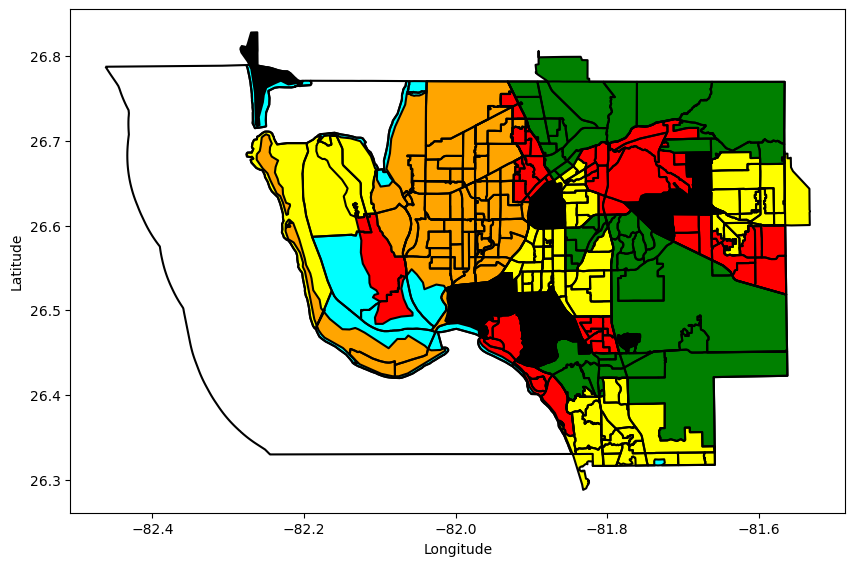

In [253]:
# sv_zone_colors = df['TRACTID'].apply(zone_to_color)
# fema_colors = zipcode_df['ZCTA5CE10'].apply(damage_to_color)
zipcode_df['zip_color'] = zipcode_df['ZCTA5CE10'].apply(damage_to_color)
sv_df['sv_color'] = df['TRACTID'].apply(zone_to_color)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

df.boundary.plot(ax=ax, edgecolor='black')
df.plot(ax=ax, color=sv_df['sv_color'])

zipcode_df.boundary.plot(ax=ax, edgecolor='black')
zipcode_df.plot(ax=ax, color=zipcode_df['zip_color'])

plt.show()